In [55]:
import numpy as np
import torch
import matplotlib.pylab as pl
import ot
import sklearn
from sklearn import datasets
import pylab
import math
import proplot as plot
plot.rc['figure.facecolor'] = "white"
from scipy.stats import random_correlation

In [48]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device='cpu'
dtype = torch.DoubleTensor
print('Used device: '+device)

torch.manual_seed(0)

Used device: cpu


In [10]:
def random_slice(n_proj,dim,device='cpu'):
    theta=torch.randn((n_proj,dim))
    theta=torch.stack([th/torch.sqrt((th**2).sum()) for th in theta])
    return theta.to(device)

def W2_line_W(X,X_line,X_line_sort,Y_line_sort,theta): 
    
    n=X.shape[0]
    
    X_proj = X_line[:,None,:]*theta[None,:,:]
    if len(X.shape)==2:
        W_s = torch.norm(X[:,:,None]-X_proj,dim=(0,1))**2
    else :
        W_s = torch.norm(X-X_proj,dim=(0,1))**2
        
    W_1d = torch.sum((X_line_sort-Y_line_sort)**2,axis=0)

    return W_s/n+W_1d/n

def upperW2(X,Y,theta):
    n=X.shape[0]

    X_line=torch.matmul(X,theta)
    Y_line=torch.matmul(Y,theta)

    X_line_sort,u=torch.sort(X_line,axis=0)
    Y_line_sort,v=torch.sort(Y_line,axis=0)
    
    Z_line_sort=(X_line_sort+Y_line_sort)/2
    Z = Z_line_sort[:,None]*theta[None,:]
   

    X_sort=X[u].transpose(1,2)
    Y_sort=Y[v].transpose(1,2)
    bary=(X_sort+Y_sort)/2

    bary_line=torch.einsum('ijk,jk->ik',bary,theta)
        
    W_baryZ=W2_line_W(bary,bary_line,bary_line,Z_line_sort,theta)
    W_XZ=W2_line_W(X,X_line,X_line_sort,Z_line_sort,theta)
    W_YZ=W2_line_W(Y,Y_line,Y_line_sort,Z_line_sort,theta)
    
    return -4*W_baryZ+2*W_XZ+2*W_YZ,u,v
def upperW2_smooth_pos(X,Y,theta,s=1,std=0):
    n,dim=X.shape
    
    X_line=torch.matmul(X,theta)
    Y_line=torch.matmul(Y,theta)
    
    X_line_sort,u=torch.sort(X_line,axis=0)
    Y_line_sort,v=torch.sort(Y_line,axis=0)
    
    X_sort=X[u]
    Y_sort=Y[v]
    
    Z_line=(X_line_sort+Y_line_sort)/2
    Z=Z_line[:,None]*theta[None,:]
    
    W_XZ=torch.sum((X_sort-Z)**2)/n
    W_YZ=torch.sum((Y_sort-Z)**2)/n
    
    X_line_extend = X_line_sort.repeat_interleave(s,dim=0)#.requires_grad_()
    X_line_extend_blur = X_line_extend + 0.5 * std * torch.randn(X_line_extend.shape).type(dtype)
    Y_line_extend = Y_line_sort.repeat_interleave(s,dim=0)#.requires_grad_()
    Y_line_extend_blur = Y_line_extend + 0.5 * std * torch.randn(Y_line_extend.shape).type(dtype)
    
    X_line_extend_blur_sort,u_b=torch.sort(X_line_extend_blur,axis=0)
    Y_line_extend_blur_sort,v_b=torch.sort(Y_line_extend_blur,axis=0)

    
    X_extend=X_sort.repeat_interleave(s,dim=0)
    Y_extend=Y_sort.repeat_interleave(s,dim=0)
    X_sort_extend=X_extend[u_b]
    Y_sort_extend=Y_extend[v_b]
    
    bary_extend=(X_sort_extend+Y_sort_extend)/2
    bary_blur=torch.mean(bary_extend.reshape((n,s,dim)),dim=1)
    
    W_baryZ=torch.sum((bary_blur-Z)**2)/n
    return -4*W_baryZ+2*W_XZ+2*W_YZ

def get_minSW_smooth_pos(X,Y,lr=1e-2,num_iter=100,s=1,std=0, seed=seed):
    theta=torch.randn((X.shape[1],), device=X.device, dtype=X.dtype,requires_grad=True)
    optimizer = torch.optim.SGD([theta], lr=lr)
    
    loss_l=torch.empty(num_iter)
    proj_l=torch.empty((num_iter,X.shape[1]))
    
    for i in range(num_iter):
        theta.data/=torch.norm(theta.data)
        
        optimizer.zero_grad()
        loss = upperW2_smooth_pos(X,Y,theta,s=s,std=std)
        loss.backward()
        optimizer.step()
        
        loss_l[i]=loss.data
        proj_l[i,:]=theta.data
    return theta, loss_l, proj_l

# Convergence in dimension 2

## sample points from 2 different gaussian distributions

In [214]:
np.random.seed(seed=2023)
n_samples = 1000
dim = 2
mu_s = np.random.randint(0,1,dim)
cov_s = np.diag(np.ones(dim))
mu_t = np.random.randint(4,5,dim)
cov_t = np.ones((dim,dim))*-.8
for i in range(dim):
    cov_t[i,i]=1

xs = np.random.multivariate_normal(mu_s, cov_s, n_samples)
xt = np.random.multivariate_normal(mu_t, cov_t, n_samples)
Xs_torch = torch.from_numpy(xs).to(device)
Xt_torch = torch.from_numpy(xt).to(device)
X, Y = Xs_torch, Xt_torch

## compute SWGG for varying number of projections + optimization

In [203]:
dim=xs.shape[1]

n_seed = 20
n_projections_arr = np.logspace(0, 3, 10, dtype=int)
res = np.empty((n_seed, 10))
res_minSWGG_2 = np.empty((n_seed, 10))

np.random.seed(seed=2023)
for seed in range(n_seed):
    for i, n_projections in enumerate(n_projections_arr):
        projections = np.random.randn(dim, n_projections)
        projections = projections / np.sqrt(np.sum(projections**2, 0, keepdims=True))
        res_minSWGG_2[seed, i]= torch.min(upperW2(X, Y, torch.from_numpy(projections).to(device))[0])
        
res_minSWGG_mean_2 = np.mean(res_minSWGG_2, axis=0)
res_minSWGG_std_2 = np.std(res_minSWGG_2, axis=0)

/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


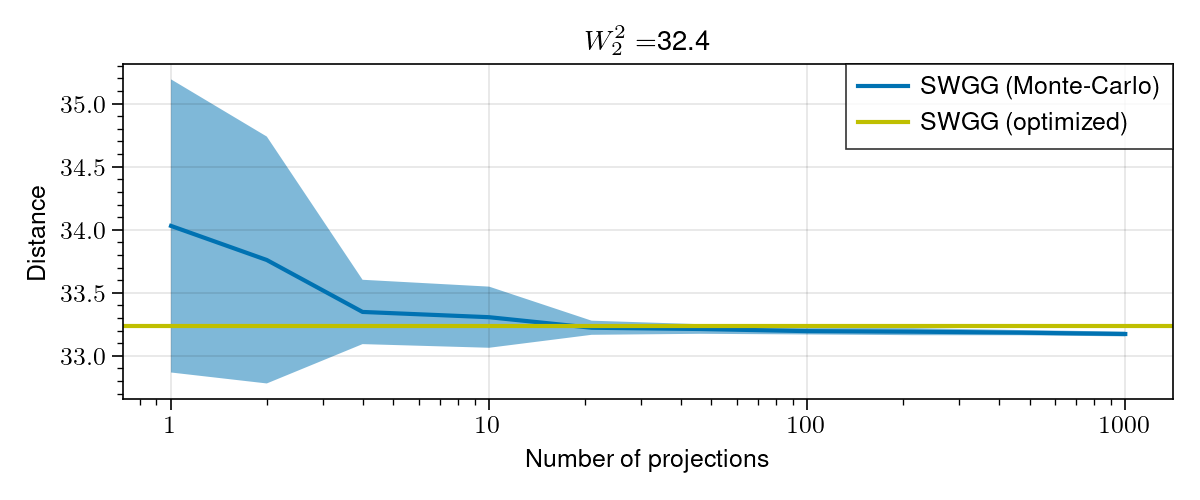

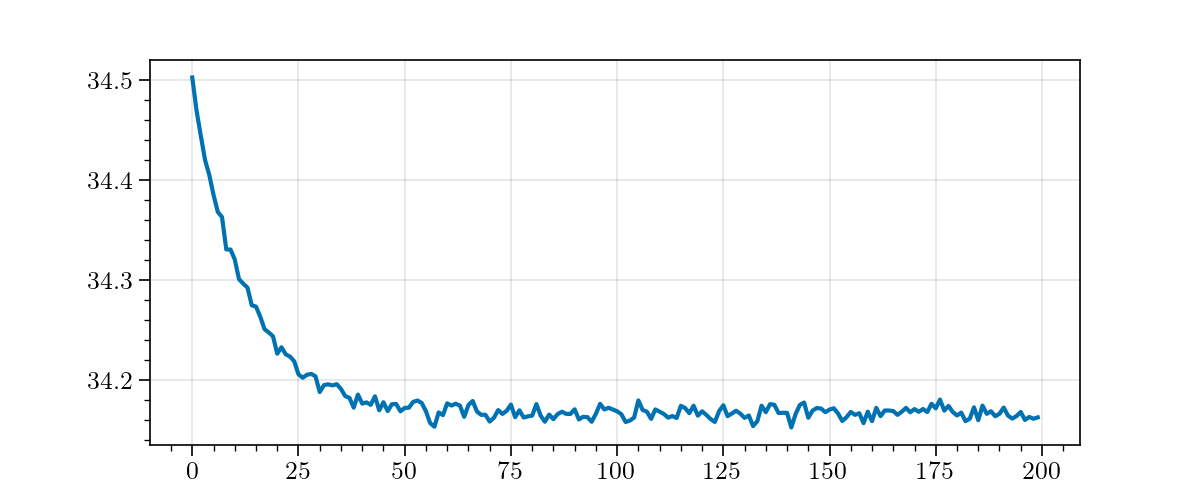

In [215]:
pl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})
lr=5e-2
num_iter=200
s = 10
std=1
t,loss_swgg_l, th = get_minSW_smooth_pos(X,Y,lr=lr,num_iter=num_iter,s=s,std=std)
t.requires_grad=False
t_min_2=t/torch.norm(t)
best_theta_2 = upperW2(X, Y, torch.reshape(t_min_2, (-1,1)))[0]

pl.figure(2)
pl.plot(n_projections_arr, res_minSWGG_mean_2, label="SWGG (Monte-Carlo)")
pl.fill_between(n_projections_arr, res_minSWGG_mean_2 - 2 * res_minSWGG_std_2, res_minSWGG_mean_2 + 2 * res_minSWGG_std_2, alpha=0.5)
pl.axhline(y = best_theta_2, color = 'y', label = 'SWGG (optimized)')

pl.legend()
pl.xscale('log')

pl.xlabel("Number of projections")
pl.ylabel("Distance")
emd2 = ot.emd2([], [], ot.dist(X.detach().numpy(), Y.detach().numpy()))
pl.title('$W_2^2 = $'+str(np.round(emd2,2)))
pl.tight_layout()
pl.savefig("montecarlo_vs_optim_dim2")
pl.show()
pl.plot(loss_swgg_l)
pl.show()

# Convergence in dimension 20

## sample points from 2 different gaussian distributions

In [227]:
np.random.seed(seed=2023)
n_samples = 1000
dim = 20
mu_s = np.random.randint(0,1,dim)
cov_s = np.diag(np.ones(dim))
mu_t = np.random.randint(4,5,dim)

#cov_s = random_correlation.rvs(np.ones(dim), random_state=2023)
#cov_t = random_correlation.rvs(np.random.randint(4,5,dim)*dim/np.sum(np.random.randint(4,5,dim)), random_state=2023)

cov_t = np.ones((dim,dim))*-.8
for i in range(dim):
    cov_t[i,i]=1

xs = np.random.multivariate_normal(mu_s, cov_s, n_samples)
xt = np.random.multivariate_normal(mu_t, cov_t, n_samples)
Xs_torch = torch.from_numpy(xs).to(device)
Xt_torch = torch.from_numpy(xt).to(device)
X, Y = Xs_torch, Xt_torch

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: covariance is not positive-semidefinite.
  app.launch_new_instance()


In [228]:
dim=xs.shape[1]

n_seed = 20
n_projections_arr = np.logspace(0, 3, 10, dtype=int)
res = np.empty((n_seed, 10))
res_minSWGG_20 = np.empty((n_seed, 10))

np.random.seed(seed=2023)
for seed in range(n_seed):
    for i, n_projections in enumerate(n_projections_arr):
        projections = np.random.randn(dim, n_projections)
        projections = projections / np.sqrt(np.sum(projections**2, 0, keepdims=True))
        res_minSWGG_20[seed, i]= torch.min(upperW2(X, Y, torch.from_numpy(projections).to(device))[0])
        
res_minSWGG_mean_20 = np.mean(res_minSWGG_20, axis=0)
res_minSWGG_std_20 = np.std(res_minSWGG_20, axis=0)

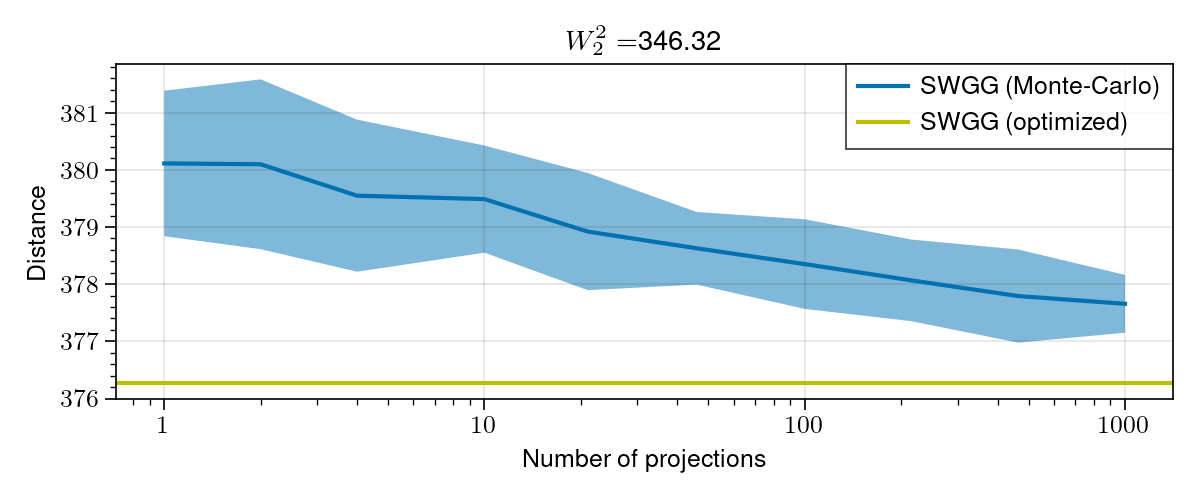

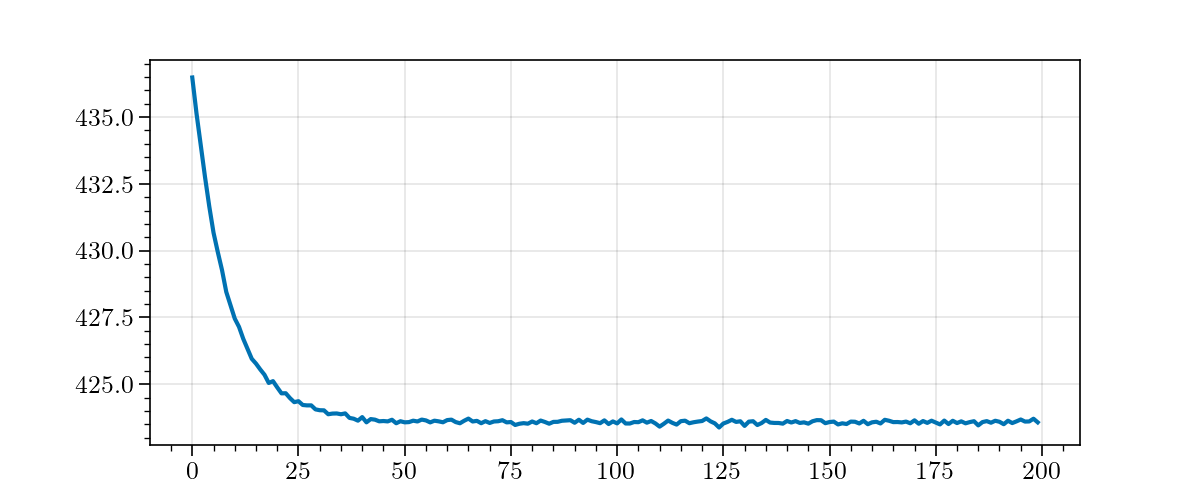

In [229]:
pl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})
lr=5e-2
num_iter=200
s = 10
std=1
t,loss_swgg_l, th = get_minSW_smooth_pos(X,Y,lr=lr,num_iter=num_iter,s=s,std=std)
t.requires_grad=False
t_min_20=t/torch.norm(t)
best_theta_20 = upperW2(X, Y, torch.reshape(t_min_20, (-1,1)))[0]
pl.figure(2)
pl.plot(n_projections_arr, res_minSWGG_mean_20, label="SWGG (Monte-Carlo)")
pl.fill_between(n_projections_arr, res_minSWGG_mean_20 - 2 * res_minSWGG_std_20, res_minSWGG_mean_20 + 2 * res_minSWGG_std_20, alpha=0.5)
pl.axhline(y = best_theta_20, color = 'y', label = 'SWGG (optimized)')

pl.legend()
pl.xscale('log')

pl.xlabel("Number of projections")
pl.ylabel("Distance")
emd20 = ot.emd2([], [], ot.dist(X.detach().numpy(), Y.detach().numpy()))
pl.title('$W_2^2 = $'+str(np.round(emd20,2)))
pl.tight_layout()
pl.savefig("montecarlo_vs_optim_dim20")

pl.show()
pl.plot(loss_swgg_l)
pl.show()

# Convergence in dimension 200

In [231]:
np.random.seed(seed=2023)
n_samples = 1000
dim = 200
mu_s = np.random.randint(0,1,dim)
cov_s = np.diag(np.ones(dim))
mu_t = np.random.randint(4,5,dim)

#cov_s = random_correlation.rvs(np.ones(dim), random_state=2023)
#cov_t = random_correlation.rvs(np.random.randint(4,5,dim)*dim/np.sum(np.random.randint(4,5,dim)), random_state=2023)

cov_t = np.ones((dim,dim))*-.8
for i in range(dim):
    cov_t[i,i]=1

xs = np.random.multivariate_normal(mu_s, cov_s, n_samples)
xt = np.random.multivariate_normal(mu_t, cov_t, n_samples)
Xs_torch = torch.from_numpy(xs).to(device)
Xt_torch = torch.from_numpy(xt).to(device)
X, Y = Xs_torch, Xt_torch

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: covariance is not positive-semidefinite.
  app.launch_new_instance()


In [232]:
dim=xs.shape[1]

n_seed = 20
n_projections_arr = np.logspace(0, 3, 10, dtype=int)
res = np.empty((n_seed, 10))
res_minSWGG_200 = np.empty((n_seed, 10))

np.random.seed(seed=2023)
for seed in range(n_seed):
    for i, n_projections in enumerate(n_projections_arr):
        projections = np.random.randn(dim, n_projections)
        projections = projections / np.sqrt(np.sum(projections**2, 0, keepdims=True))
        res_minSWGG_200[seed, i]= torch.min(upperW2(X, Y, torch.from_numpy(projections).to(device))[0])
        
res_minSWGG_mean_200 = np.mean(res_minSWGG_200, axis=0)
res_minSWGG_std_200 = np.std(res_minSWGG_200, axis=0)

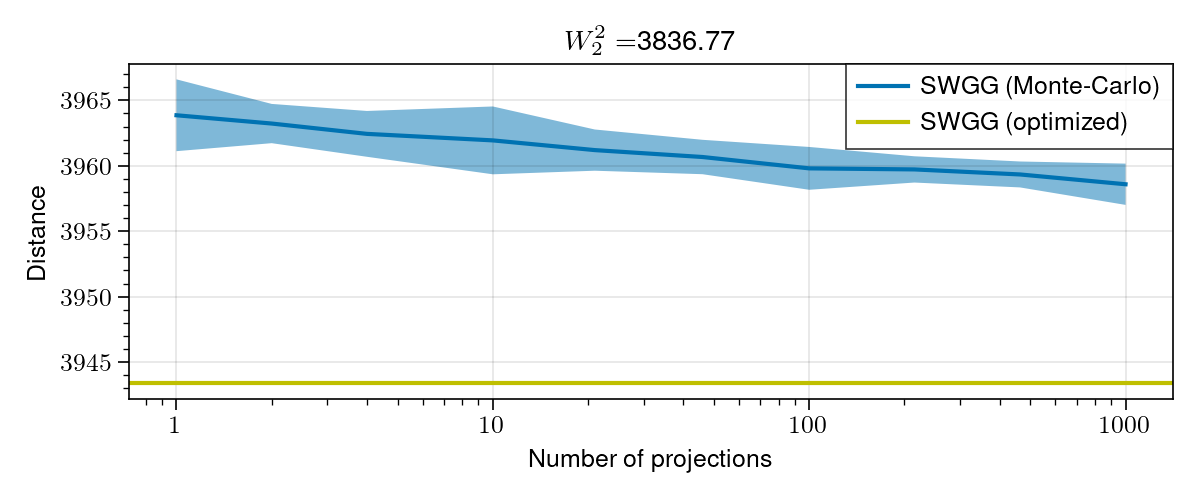

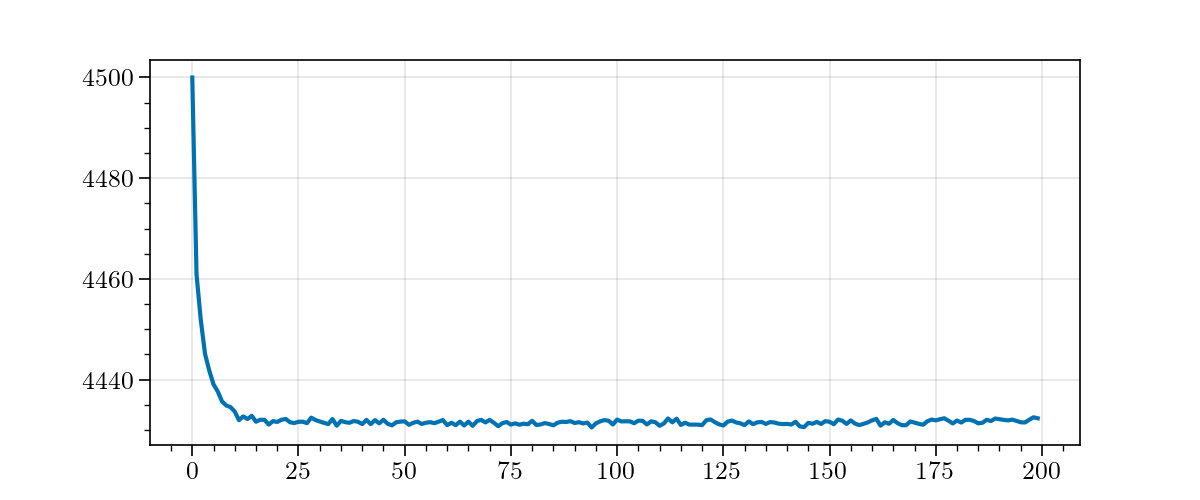

In [233]:
pl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})
lr=5e-2
num_iter=200
s = 10
std=1
t,loss_swgg_l, th = get_minSW_smooth_pos(X,Y,lr=lr,num_iter=num_iter,s=s,std=std)
t.requires_grad=False
t_min_200=t/torch.norm(t)
best_theta_200 = upperW2(X, Y, torch.reshape(t_min_200, (-1,1)))[0]
pl.figure(2)
pl.plot(n_projections_arr, res_minSWGG_mean_200, label="SWGG (Monte-Carlo)")
pl.fill_between(n_projections_arr, res_minSWGG_mean_200 - 2 * res_minSWGG_std_200, res_minSWGG_mean_200 + 2 * res_minSWGG_std_200, alpha=0.5)
pl.axhline(y = best_theta_200, color = 'y', label = 'SWGG (optimized)')

pl.legend()
pl.xscale('log')

pl.xlabel("Number of projections")
pl.ylabel("Distance")
emd_200 = ot.emd2([], [], ot.dist(X.detach().numpy(), Y.detach().numpy()))
pl.title('$W_2^2 = $'+str(np.round(emd_200,2)))
pl.tight_layout()
pl.savefig("montecarlo_vs_optim_dim200.pdf")
pl.show()
pl.plot(loss_swgg_l)
pl.show()

# final figure

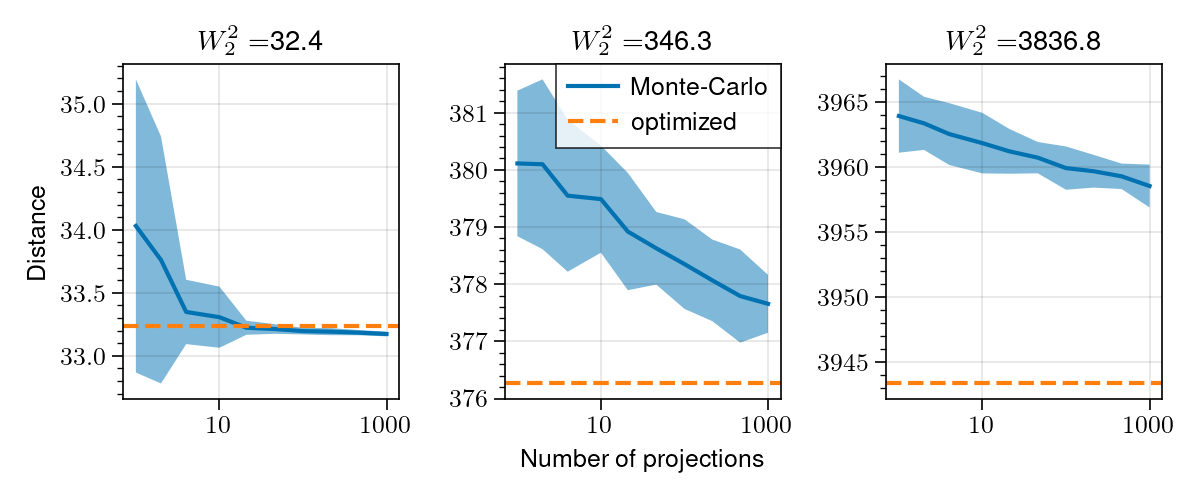

In [239]:
pl.rcParams["figure.figsize"] = (6,2.5)
pl.subplot(131)
pl.xscale('log')
pl.plot(n_projections_arr, res_minSWGG_mean_2)
pl.fill_between(n_projections_arr, res_minSWGG_mean_2 - 2 * res_minSWGG_std_2, res_minSWGG_mean_2 + 2 * res_minSWGG_std_2, alpha=0.5)
pl.axhline(y = best_theta_2,color='tab:orange', ls='--' )

pl.ylabel("Distance")
pl.title('$W_2^2 = $'+str(np.round(emd2,1)))
pl.tight_layout()

pl.subplot(132)
pl.xscale('log')
pl.plot(n_projections_arr, res_minSWGG_mean_20, label="Monte-Carlo")
pl.fill_between(n_projections_arr, res_minSWGG_mean_20 - 2 * res_minSWGG_std_20, res_minSWGG_mean_20 + 2 * res_minSWGG_std_20, alpha=0.5)
pl.axhline(y = best_theta_20,color='tab:orange', ls='--', label="optimized" )
pl.xlabel("Number of projections")
pl.title('$W_2^2 = $'+str(np.round(emd20,1)))
pl.legend()
pl.subplot(133)
pl.xscale('log')
pl.plot(n_projections_arr, res_minSWGG_mean)
pl.fill_between(n_projections_arr, res_minSWGG_mean - 2 * res_minSWGG_std, res_minSWGG_mean + 2 * res_minSWGG_std, alpha=0.5)
pl.axhline(y = best_theta_200,color='tab:orange', ls='--', label="optimized" )
pl.title('$W_2^2 = $'+str(np.round(emd_200,1)))
pl.tight_layout()
pl.savefig("montecarlo_vs_optim.pdf")